## EDA


=== 1. Basic Overview ===
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 68040 entries, 72 to 143808
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    68040 non-null  datetime64[ns]
 1   RegionName              68040 non-null  object        
 2   AreaCode                68040 non-null  object        
 3   AveragePrice            68040 non-null  float64       
 4   Index                   68040 non-null  float64       
 5   IndexSA                 68040 non-null  float64       
 6   1m%Change               68040 non-null  float64       
 7   12m%Change              68040 non-null  float64       
 8   AveragePriceSA          68040 non-null  float64       
 9   SalesVolume             68040 non-null  float64       
 10  DetachedPrice           68040 non-null  float64       
 11  DetachedIndex           68040 non-null  float64       
 12  Detach

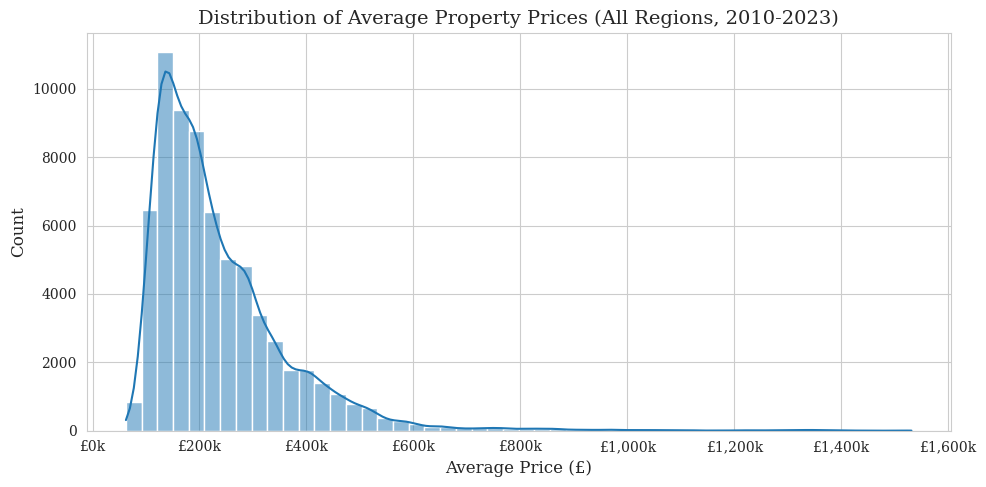

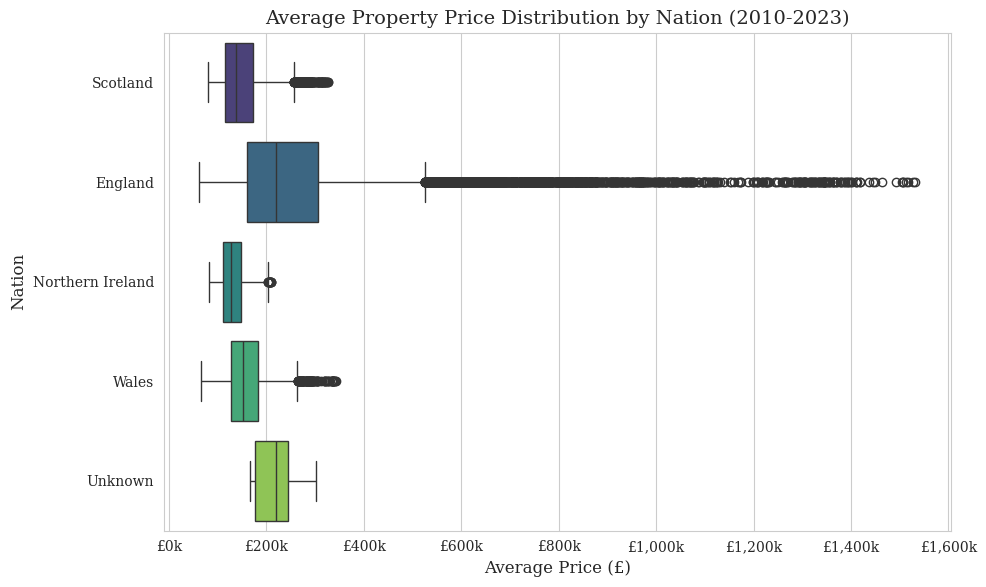


=== 3. Trends Over Time ===


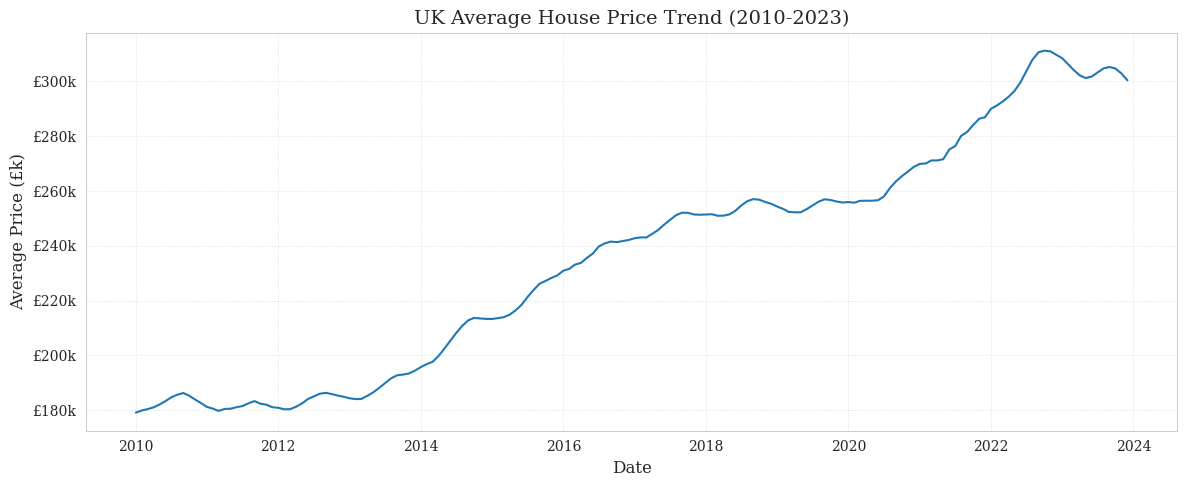

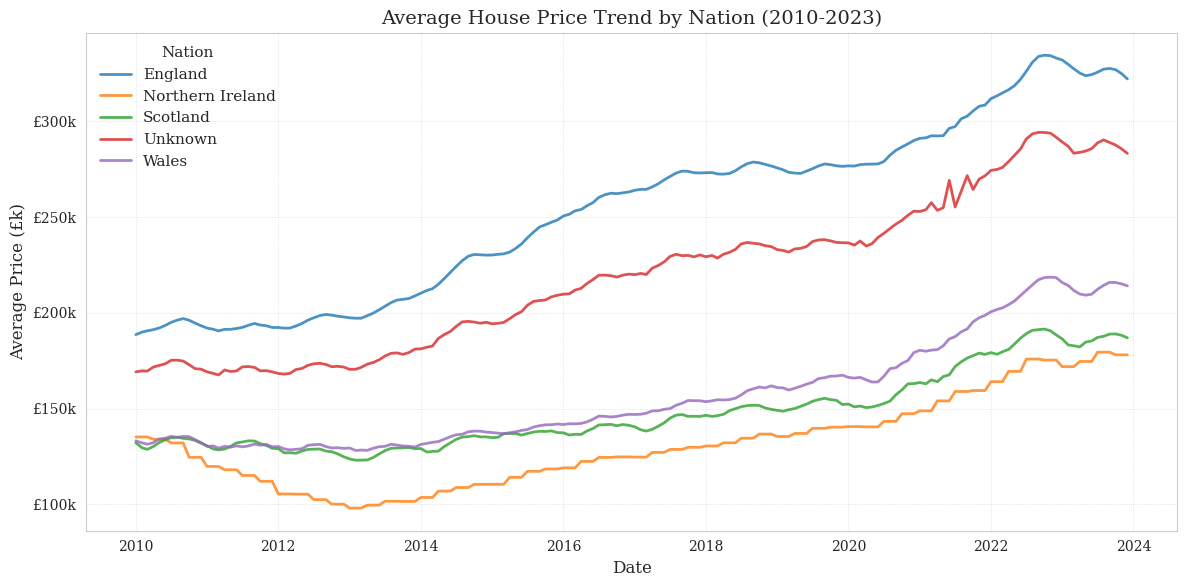

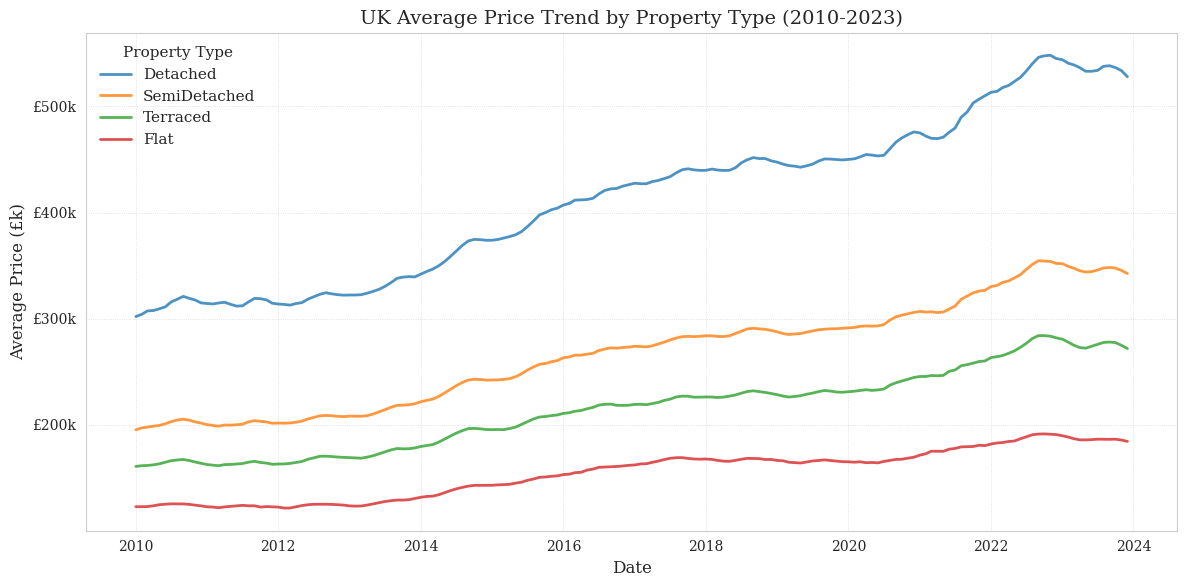

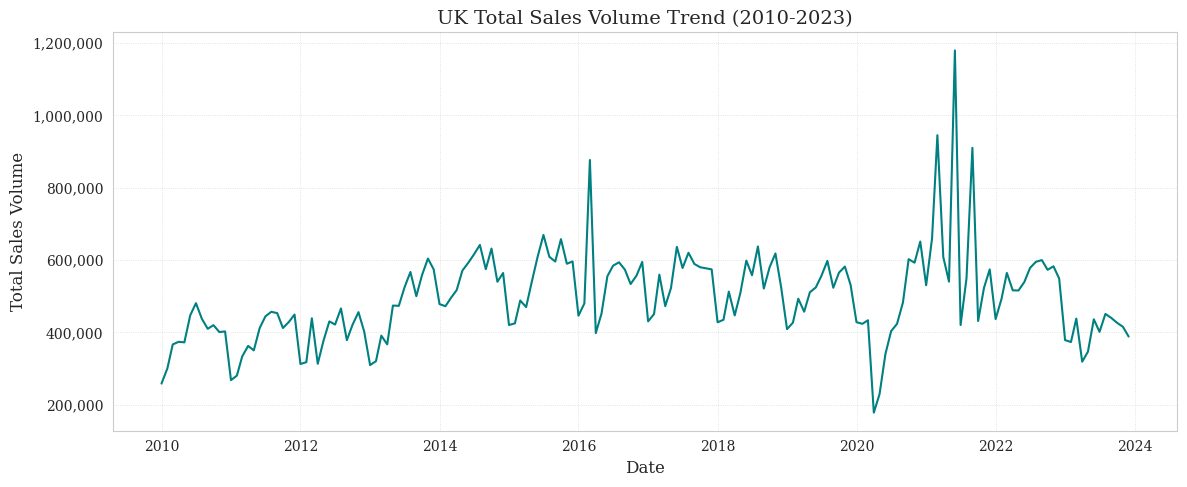


=== 4. Seasonality & Autocorrelation (UK Average Price) ===


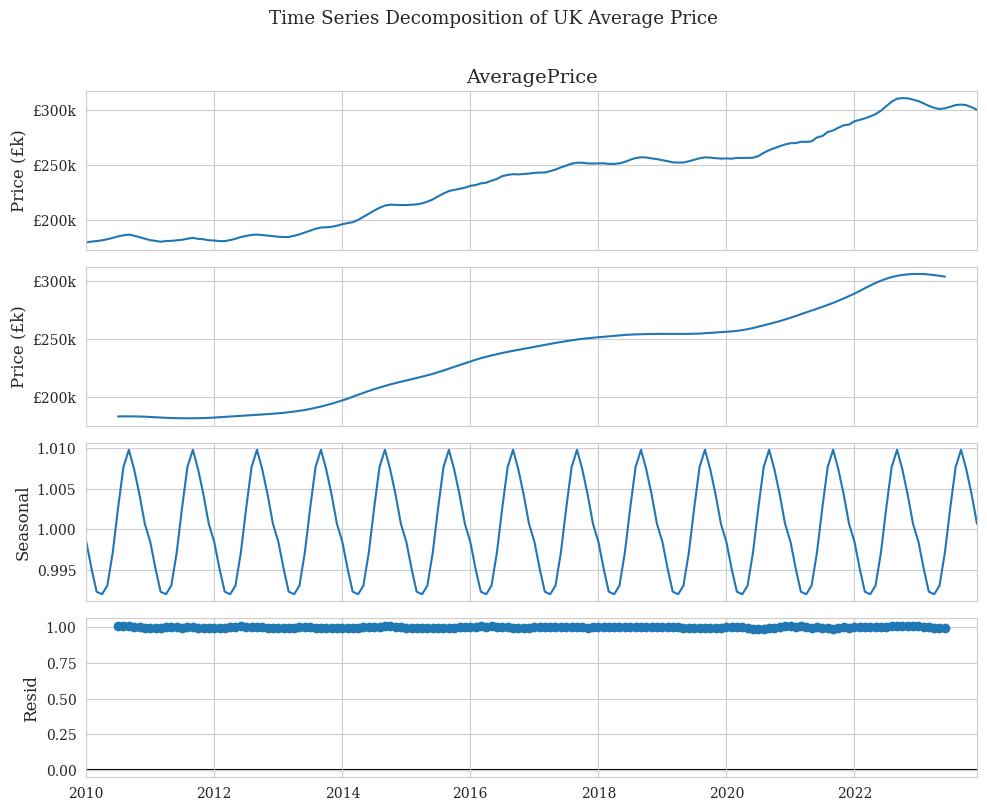

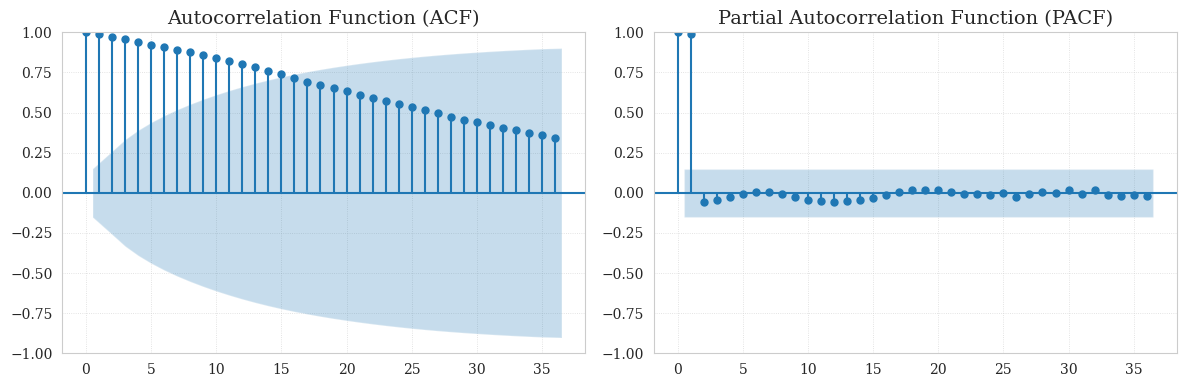


=== 5. Regional Comparison ===


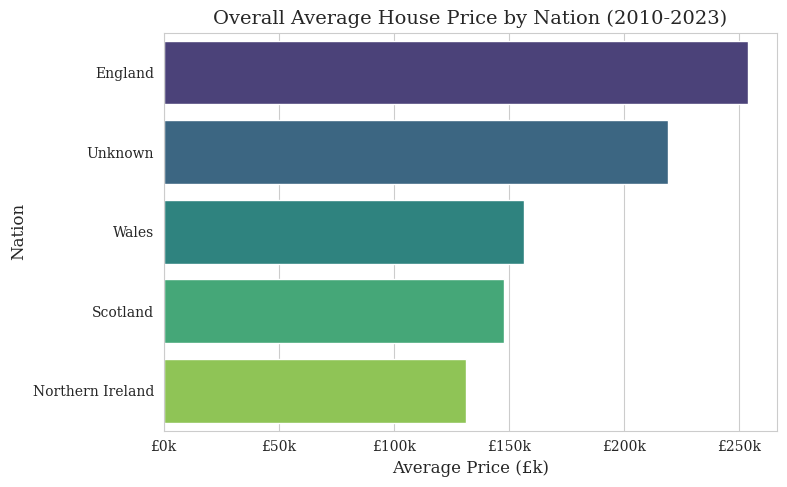


Calculating YoY % Change by Nation...


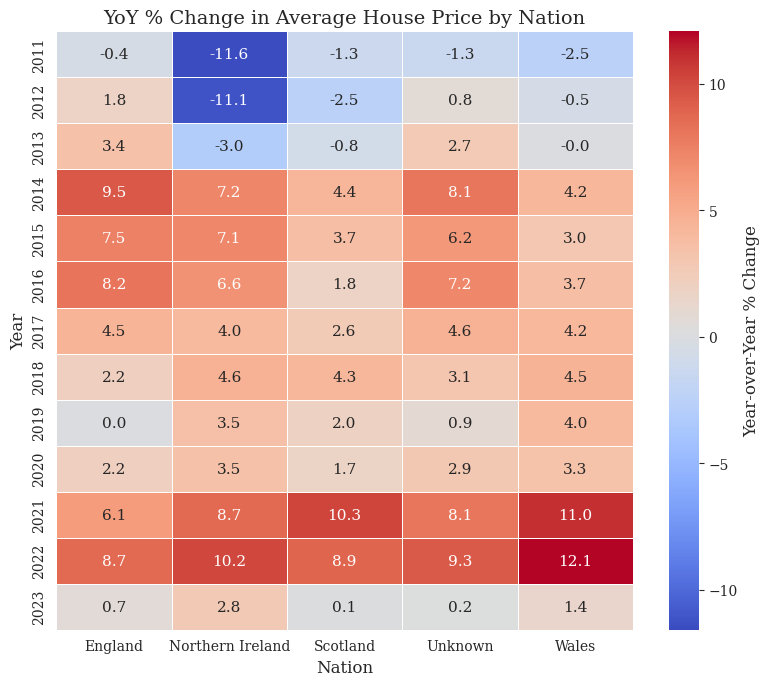


=== 7. Property Type Analysis ===


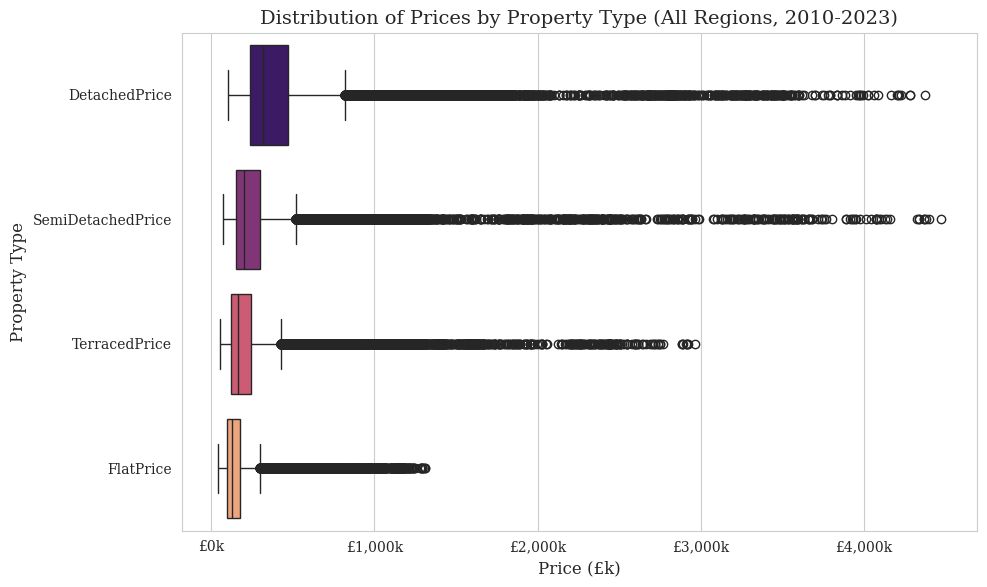

In [86]:
# --- Set Plot Style ---
sns.set_style("whitegrid")
plt.rc('font', family='serif', size=11)
plt.rc('axes', titlesize=14, labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
currency_formatter = mticker.FuncFormatter(lambda x, p: f'£{x/1e3:,.0f}k') # Format as £k

# === Basic Overview ===
print("=== Basic Overview ===")
print("DataFrame Info:")
df_processed.info()
print("\nDescriptive Statistics (Numeric Columns):")
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(df_processed.describe().to_markdown())

# === Price Distributions ===
print("=== Price Distributions ===")

# a) Distribution of UK Average Price (using all regional entries)
plt.figure(figsize=(10, 5))
sns.histplot(df_processed['AveragePrice'], bins=50, kde=True)
plt.title('Distribution of Average Property Prices (All Regions, 2010-2023)')
plt.xlabel('Average Price (£)')
plt.gca().xaxis.set_major_formatter(currency_formatter)
plt.tight_layout()
plt.show()

# b) Average Price Distribution by Nation
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_processed, x='AveragePrice', y='Nation', palette='viridis')
plt.title('Average Property Price Distribution by Nation (2010-2023)')
plt.xlabel('Average Price (£)')
plt.ylabel('Nation')
plt.gca().xaxis.set_major_formatter(currency_formatter)
plt.tight_layout()
plt.show()

# === Trends Over Time ===
print("=== Trends Over Time ===")

# Aggregate data monthly for national trends
df_avg_time = df_processed.groupby('Date')['AveragePrice'].mean().asfreq('MS').ffill().bfill()
df_volume_time = df_processed.groupby('Date')['SalesVolume'].sum().asfreq('MS').fillna(0) # Sum volume
df_types_time = df_processed.groupby('Date')[["DetachedPrice", "SemiDetachedPrice", "TerracedPrice", "FlatPrice"]].mean().asfreq('MS').ffill().bfill()

# a) UK Average Price Trend
plt.figure(figsize=(12, 5))
plt.plot(df_avg_time.index, df_avg_time, label='UK Average Price')
plt.title('UK Average House Price Trend (2010-2023)')
plt.xlabel('Date')
plt.ylabel('Average Price (£k)')
plt.gca().yaxis.set_major_formatter(currency_formatter)
plt.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

# b) Average Price Trend by Nation
plt.figure(figsize=(12, 6))

nation_trends = df_processed.groupby(['Date', 'Nation'])['AveragePrice'].mean().unstack()
for nation in nation_trends.columns:
    plt.plot(nation_trends.index, nation_trends[nation], label=nation, lw=2, alpha=0.8)
plt.title('Average House Price Trend by Nation (2010-2023)')
plt.xlabel('Date')
plt.ylabel('Average Price (£k)')
plt.gca().yaxis.set_major_formatter(currency_formatter)
plt.legend(title='Nation', frameon=False)
plt.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

# c) UK Average Component Price Trends
plt.figure(figsize=(12, 6))
for col in df_types_time.columns:
    plt.plot(df_types_time.index, df_types_time[col], label=col.replace('Price',''), lw=2, alpha=0.8)
plt.title('UK Average Price Trend by Property Type (2010-2023)')
plt.xlabel('Date')
plt.ylabel('Average Price (£k)')
plt.gca().yaxis.set_major_formatter(currency_formatter)
plt.legend(title='Property Type', frameon=False)
plt.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

# d) UK Total Sales Volume Trend
plt.figure(figsize=(12, 5))
plt.plot(df_volume_time.index, df_volume_time, label='Total UK Sales Volume', color='teal')
plt.title('UK Total Sales Volume Trend (2010-2023)')
plt.xlabel('Date')
plt.ylabel('Total Sales Volume')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:,.0f}')) # Comma format
plt.grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

# === Seasonality & Autocorrelation (UK Average Price) ===
print("=== Seasonality & Autocorrelation (UK Average Price) ===")

# Performing seasonal decomposition
decomposition = seasonal_decompose(df_avg_time.dropna(), model='multiplicative', period=12) # Assuming monthly data, multiplicative might fit price data well

# Plotting decomposition
fig_decomp = decomposition.plot()
fig_decomp.set_size_inches(10, 8)
plt.suptitle('Time Series Decomposition of UK Average Price', y=1.01)
# Format y-axis of trend and observed
for ax in fig_decomp.axes[:2]: # First two axes are observed and trend
     ax.yaxis.set_major_formatter(currency_formatter)
     ax.set_ylabel("Price (£k)") # Relabel
plt.tight_layout()
plt.show()

# Plotting ACF and PACF
fig_acf_pacf, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_avg_time.dropna(), lags=36, ax=axes[0], title='Autocorrelation Function (ACF)')
plot_pacf(df_avg_time.dropna(), lags=36, ax=axes[1], title='Partial Autocorrelation Function (PACF)', method='ywm')
axes[0].grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
axes[1].grid(True, linestyle=":", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

# === Regional Comparison ===
print("=== Regional Comparison ===")

# a) Bar Chart of Average Price by Nation (Overall Period)
avg_price_nation = df_processed.groupby('Nation')['AveragePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_nation.values, y=avg_price_nation.index, palette='viridis', orient='h')
plt.title('Overall Average House Price by Nation (2010-2023)')
plt.xlabel('Average Price (£k)')
plt.ylabel('Nation')
plt.gca().xaxis.set_major_formatter(currency_formatter)
plt.tight_layout()
plt.show()

# b) Heatmap of YoY Percentage Change by Nation
print("Calculating YoY % Change by Nation")
try:
    if 'Year' not in df_processed.columns: df_processed['Year'] = df_processed['Date'].dt.year
    annual_prices_nation = df_processed.groupby(["Nation", "Year"])["AveragePrice"].mean().reset_index()
    pivot_prices_nation = annual_prices_nation.pivot(index="Year", columns="Nation", values="AveragePrice")
    yoy_pct_change_nation = pivot_prices_nation.pct_change() * 100

    plt.figure(figsize=(8, 7))
    sns.heatmap(yoy_pct_change_nation.iloc[1:], # Skip first NaN row
                annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5,
                cbar_kws={'label': 'Year-over-Year % Change'})
    plt.title('YoY % Change in Average House Price by Nation')
    plt.ylabel('Year')
    plt.xlabel('Nation')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate YoY heatmap: {e}")


# === Property Type Analysis ===
print("===Property Type Analysis ===")

# a) Boxplot of Component Prices
prop_types_long = df_processed[['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']].melt(var_name='PropertyType', value_name='Price')
plt.figure(figsize=(10, 6))
sns.boxplot(data=prop_types_long, x='Price', y='PropertyType', palette='magma')
plt.title('Distribution of Prices by Property Type (All Regions, 2010-2023)')
plt.xlabel('Price (£k)')
plt.ylabel('Property Type')
plt.gca().xaxis.set_major_formatter(currency_formatter)
plt.tight_layout()
plt.show()